# Project 2 ECE 236A - Making Plots

**Samuel Gessow** (sgessow@gmail.com), **Steven Zhiying Li** (zhiyingli@g.ucla.edu), **Sunay Bhat** (sunaybhat1@ucla.edu), **Terri Tsai** (terri0716@gmail.com), **Dominic Yang** (domyang@g.ucla.edu)

**This is the jupyter notebook that helps generate the graphs we have in the report.**

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cp

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
import MyDecoder as decoder

# for automatically reloading the imported modules
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
num_trial = 100
letter_list = ['a', 'b', 'c', 'd']
color_list = ['#0366d6', '#d73a49', '#28a745', '#ffd33d', '#6a737d']

In [ ]:
def run_lp_trials(n, p, T_list, num_trial, func=decoder.lp, q=None, m=None,
                  p_noisy=None, noise_type=None, verbose=True):
    Hamming_err_lists = []
    FN_lists = []
    FP_lists = []

    for i in range(num_trial):
        Hamming_err_list = []
        FN_list = []
        FP_list = []

        for T in T_list:
            if m is not None:
                X, ppl, y, A = decoder.generator_nonoverlapping(n, q, p, m, T)
            else:
                X, ppl, y = decoder.generator(n, p, T)

            if noise_type == 'z':
                y = decoder.add_noise_zchannel(y, p_noisy)
            elif noise_type == 'bsc':
                y = decoder.add_noise_bsc(y, p_noisy)

            if m is not None:
                ppl_pred  = func(X, y, A)
            else:
                ppl_pred = func(X, y)

            if verbose:
                print("Solved Trial: ",i, " for T=",T)
            Hamming_err = sum(ppl_pred != ppl)
            Hamming_err_list.append(Hamming_err)

            positive_mask = (ppl == 1)
            FN = sum(ppl_pred[positive_mask] == 0)
            FN_list.append(FN)

            negative_mask = (ppl == 0)
            FP = sum(ppl_pred[negative_mask] == 1)
            FP_list.append(FP)

        Hamming_err_lists.append(Hamming_err_list)
        FN_lists.append(FN_list)
        FP_lists.append(FP_list)

    return Hamming_err_lists, FN_lists, FP_lists

In [ ]:
def make_plot(n, p, Hamming_err_lists, FN_lists, FP_lists, T_list, num_trial, c='blue', test='',
              m=None, q=None, p_noisy=None, noise_type=None, title='', plot_distribution=True):
    AVG_Hamming_err_list = np.average(Hamming_err_lists,axis=0)
    AVG_FN_list = np.average(FN_lists,axis=0)
    AVG_FP_list = np.average(FP_lists,axis=0)

    up_lim = np.amax(np.array([AVG_Hamming_err_list/n, AVG_FN_list/n, AVG_FP_list/n])) + 0.02
    low_lim = -0.05*up_lim

    plt.subplot(1,3,1)
    plt.plot(T_list, AVG_FP_list/n, '-o',  label = test, linewidth = 3, color = c)
    if plot_distribution:
        e_list = (np.max(np.array(FP_lists), axis = 0) - np.min(np.array(FP_lists), axis = 0))/4.0
        plt.errorbar(T_list, AVG_FP_list/n, e_list/n, linestyle='None', marker='None', color = c, alpha = 0.8)
    plt.xlabel("T (Number of Tests)")
    plt.ylabel("False Positive")
    plt.ylim(low_lim, up_lim)
    plt.title("T (Number of Tests) vs False Positive",fontweight="bold", fontsize=12)
    plt.grid(True)
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(T_list, AVG_FN_list/n, '-o',  label = test, linewidth = 3, color = c)
    if plot_distribution:
        e_list = (np.max(np.array(FN_lists), axis = 0) - np.min(np.array(FN_lists), axis = 0))/4.0
        plt.errorbar(T_list, AVG_FN_list/n, e_list/n, linestyle='None', marker='None', color = c,  alpha = 0.8)
    plt.xlabel("T (Number of Tests)")
    plt.ylabel("False Negative")
    plt.ylim(low_lim, up_lim)
    plt.title("T (Number of Tests) vs False Negative",fontweight="bold", fontsize=12)
    plt.grid(True)
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(T_list, AVG_Hamming_err_list/n, '-o', label = test, linewidth = 3, color = c)
    if plot_distribution:
        e_list = (np.max(np.array(Hamming_err_lists), axis = 0) - np.min(np.array(Hamming_err_lists), axis = 0))/4.0
        plt.errorbar(T_list, AVG_Hamming_err_list/n, e_list/n, linestyle='None', marker='None', color = c, alpha = 0.8)
    plt.xlabel("T (Number of Tests)")
    plt.ylabel("Hamming Error Rate")
    plt.ylim(low_lim, up_lim)
    plt.title("T (Number of Tests) vs Hamming Error Rate", fontweight="bold", fontsize=12)
    plt.grid(True)
    plt.legend()

In [ ]:
def legend_entry(p, m=None, q=None, p_noisy=None, noise_type=None):
    title = f"p = {p} "
    if q is not None:
        title += f', q = {q}, m={m}'
    if p_noisy is not None:
        if noise_type == 'z':
            title += f', p_noisy (z) = {p_noisy}'
        elif noise_type == 'bsc':
            title += f', p_noisy (bsc) = {p_noisy}'
    return title

# 1. Assume the *noiseless prior*

## 1.1. Without Community Structure (Method: Basic LP, Dynamic Rounding)

In [ ]:
# lp : No community structure, Without Noise (Method: Basic LP, Dynamic Rounding)
def plot_lp(n, T_list, ps, num_trial, verbose=True):
    color_list = ['#79b8ff', '#005cc5']
    fig = plt.figure()
    c_index = 0

    for p in ps:
        out = run_lp_trials(n, p, T_list, num_trial, func=decoder.lp, q=None, m=None,
                  p_noisy=None, noise_type=None, verbose=verbose)
        hamming_err_lists, fn_lists, fp_lists = out
        label = legend_entry(p)
        make_plot(n, p, hamming_err_lists, fn_lists, fp_lists, T_list, num_trial,
                  q=None, p_noisy=None, noise_type=None, test=label, c = color_list[c_index])
        c_index += 1

    filename = 'lp.png'
    fig.set_size_inches(18, 4)
    plt.savefig(filename)
    plt.show()
    plt.close()

    return

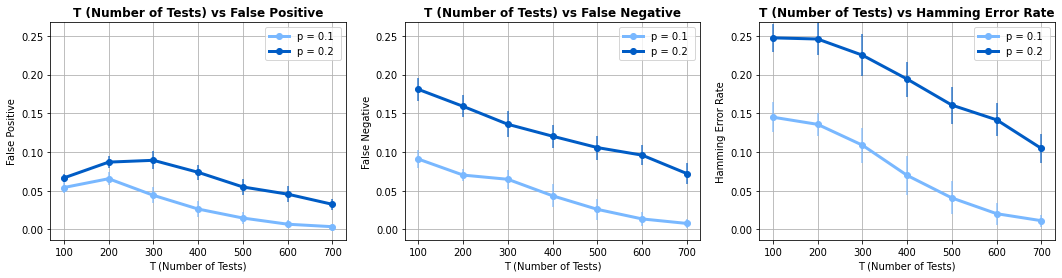

In [5]:
n = 1000
T_list = [100, 200, 300, 400, 500, 600, 700] 
ps = [0.1, 0.2]
verbose = False
plot_lp(n, T_list, ps, num_trial,verbose)

## 1.2. With Conmunity Structure, Without Noise (Method: Alternative LP, Dynamic Rounding) 

In [ ]:
# lp_nonoverlapping: Conmunity Structure, Without Noise (Method: Alternative LP, Dynamic Rounding)
def plot_lp_nonoverlapping(n, T_list, ps, qs, ms, num_trial, verbose=True):
    color_list = ['#cb2431','#f97583', '#22863a', '#34d058']
    case_num = 1

    c_index = 0
    for m in ms: # first case 1 then case 2
        print("("+letter_list[case_num-1]+"): Case "+str(case_num))
        fig = plt.figure()

        for p, q in zip(ps, qs):
            out = run_lp_trials(n, p, T_list, num_trial, func=decoder.lp_nonoverlapping,
                      q=q, m=m, p_noisy=None, noise_type=None, verbose=verbose)
            hamming_err_lists, fn_lists, fp_lists = out
            label = legend_entry(p, m=m, q=q)
            make_plot(n, p, hamming_err_lists, fn_lists, fp_lists, T_list, num_trial,
                      q=q, m=m, p_noisy=None, noise_type=None, test=label, c = color_list[c_index])
            c_index += 1

        filename = 'lp_nonoverlapping (case '+str(case_num)+').png'
        case_num += 1
        fig.set_size_inches(18, 4)
        plt.savefig(filename)
        plt.show()
        plt.close()

    return

(a): Case 1


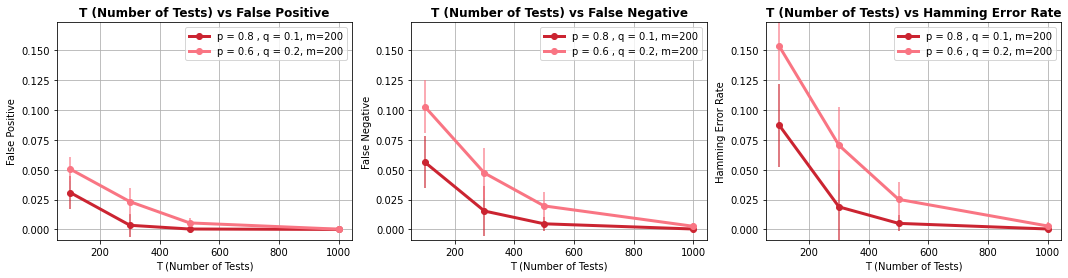

(b): Case 2


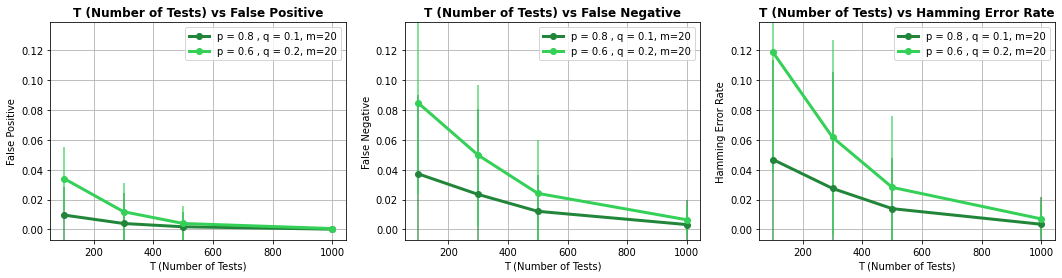

In [6]:
n = 1000
T_list = [100, 300, 500, 1000]
ps = [0.8, 0.6]
qs = [0.1, 0.2]
ms = [200, 20]
verbose = False

plot_lp_nonoverlapping(n, T_list, ps, qs, ms, num_trial, verbose)

# 2. Assume the *$z$-channel Noise*

## 2.1. Without Community Structure (Method: Basic LP with Slack, Naive Rounding)

In [ ]:
# lp_noisy_z: Without Community Structure (Method: Basic LP with Slack, Naive Rounding) With z channel noise
def plot_lp_noisy_z(n, T_list, ps, p_noisys, num_trial, verbose=True):
    color_list = ['#005cc5', '#79b8ff']


    for p_noisy in p_noisys:
        c_index = 0
        print("flipping over probability is "+str(p_noisy))
        case_num = 1
        fig = plt.figure()

        for p in ps:
            out = run_lp_trials(n, p, T_list, num_trial, func=decoder.lp_noisy_z, q=None, m=None,
                      p_noisy=p_noisy, noise_type='z', verbose=verbose)
            hamming_err_lists, fn_lists, fp_lists = out
            label = legend_entry(p, p_noisy=p_noisy, noise_type='z')
            make_plot(n, p, hamming_err_lists, fn_lists, fp_lists, T_list, num_trial,
                      q=None, p_noisy=p_noisy, noise_type='z', test=label, c = color_list[c_index])
            c_index += 1

        filename = 'lp_noisy_z (p_noisy = '+str(p_noisy)+').png'
        fig.set_size_inches(18, 4)
        plt.savefig(filename)
        plt.show()
        plt.close()

    return

flipping over probability is 0.1


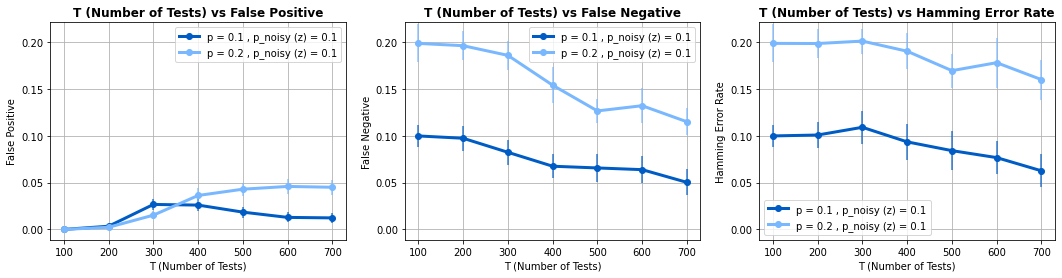

flipping over probability is 0.2


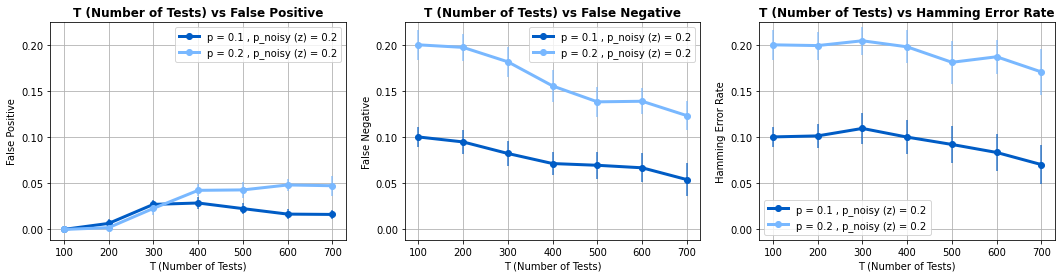

In [7]:
n = 1000
T_list = [100, 200, 300, 400, 500, 600, 700]
ps = [0.1, 0.2]
p_noisys = [0.1, 0.2]
verbose = False

plot_lp_noisy_z(n, T_list, ps, p_noisys, num_trial, verbose)

## 2.1. With Community Structure (Method: Basic LP with Slack, Naive Rounding)

In [ ]:
def plot_lp_noisy_z_nonoverlapping(n, T_list, ps, qs, ms, p_noisys, num_trial, verbose=True):
    color_list = ['#cb2431','#f97583', '#22863a', '#34d058']
    noisy_num = 1

    for p_noisy in p_noisys:
        print("flipping over probability is "+str(p_noisy))
        case_num = 1
        c_index = 0

        for m in ms:
            print("("+letter_list[case_num-1]+"): Case "+str(case_num))
            fig = plt.figure()

            for p, q in zip(ps, qs):
                    out = run_lp_trials(n, p, T_list, num_trial, func=decoder.lp_noisy_z_nonoverlapping,
                              q=q, m=m, p_noisy=p_noisy, noise_type='z', verbose=verbose)
                    hamming_err_lists, fn_lists, fp_lists = out
                    label = legend_entry(p, m=m, q=q, p_noisy=p_noisy, noise_type='z')
                    make_plot(n, p, hamming_err_lists, fn_lists, fp_lists, T_list, num_trial,
                              q=q, m=m, p_noisy=p_noisy, noise_type='z', test=label, c = color_list[c_index])
                    c_index += 1
            filename = 'lp_noisy_z_nonoverlapping (p_noisy = '+str(p_noisy)+', case '+str(case_num)+').png'
            case_num += 1
            fig.set_size_inches(18, 4)
            plt.savefig(filename)
            plt.show()
            plt.close()

        noisy_num += 1
    return

flipping over probability is 0.1
(a): Case 1


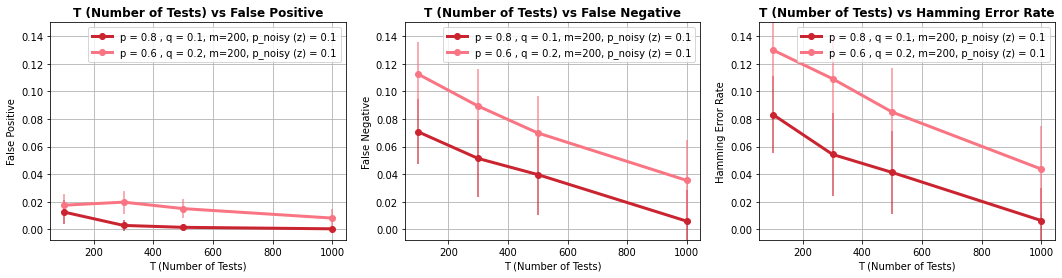

(b): Case 2


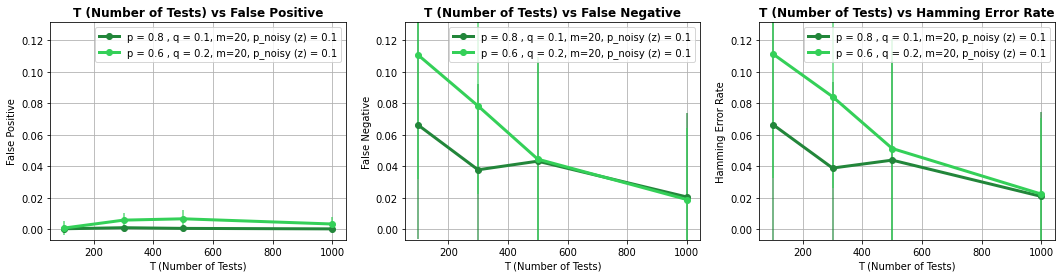

flipping over probability is 0.2
(a): Case 1


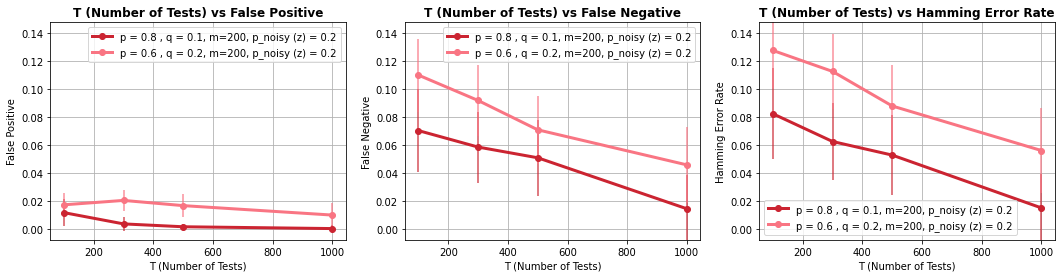

(b): Case 2


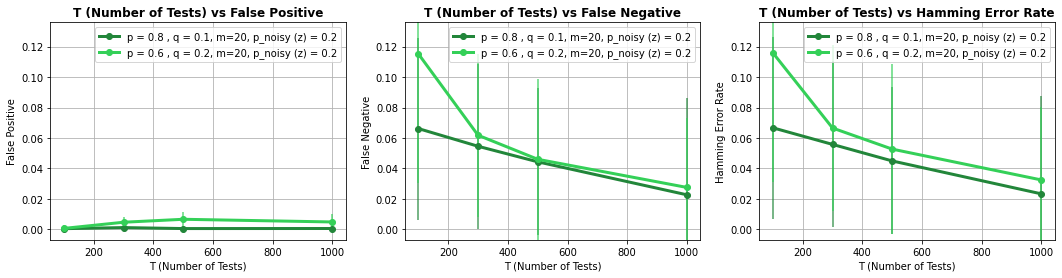

In [8]:
n = 1000
T_list = [100, 300, 500, 1000]
ps = [0.8, 0.6]
qs = [0.1, 0.2]
ms = [200, 20]
p_noisys = [0.1, 0.2]
verbose = False

plot_lp_noisy_z_nonoverlapping(n, T_list, ps, qs, ms, p_noisys, num_trial, verbose)

# 3. Assume the *Basic Channel Noise*

## 3.1. Without Community Structure (Method: Basic LP with Slack, Naive Rounding)

In [ ]:
# lp_noisy_bsc: Without Community Structure (Method: Basic LP with Slack, Naive Rounding) Assume Basic Channel Noise
def plot_lp_noisy_bsc(n, T_list, ps, p_noisys, num_trial, verbose=True):
    color_list = ['#005cc5', '#79b8ff']

    noisy_num = 1
    for p_noisy in p_noisys:
        print("("+letter_list[noisy_num-1]+"): flipping over probability is "+str(p_noisy))
        fig = plt.figure()
        c_index = 0

        for p in ps:
            out = run_lp_trials(n, p, T_list, num_trial, func=decoder.lp_noisy_bsc, q=None, m=None,
                      p_noisy=p_noisy, noise_type='bsc', verbose=verbose)
            hamming_err_lists, fn_lists, fp_lists = out
            label = legend_entry(p, p_noisy=p_noisy, noise_type='z')
            make_plot(n, p, hamming_err_lists, fn_lists, fp_lists, T_list, num_trial,
                      q=None, p_noisy=p_noisy, noise_type='bsc', test=label, c = color_list[c_index])
            c_index += 1

        filename = 'lp_noisy_bsc (p_noisy = '+str(p_noisy)+').png'
        noisy_num += 1
        fig.set_size_inches(18, 4)
        plt.savefig(filename)
        plt.show()
        plt.close()
    return

(a): flipping over probability is 0.1


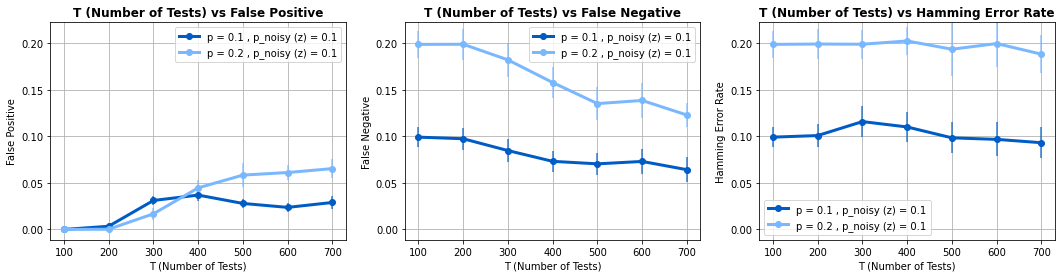

(b): flipping over probability is 0.2


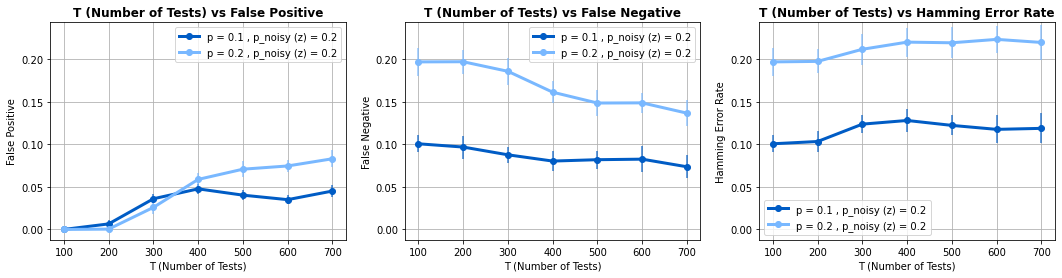

In [9]:
n = 1000
T_list = [100, 200, 300, 400, 500, 600, 700]
ps = [0.1, 0.2]
p_noisys = [0.1, 0.2]
verbose = False

plot_lp_noisy_bsc(n, T_list, ps, p_noisys, num_trial, verbose)

## 3.2. With Community Structure (Method: Alternative LP with Slack, Naive Rounding)

In [ ]:
def plot_lp_noisy_bsc_nonoverlapping(n, T_list, ps, qs, ms, p_noisys, num_trial, verbose=True):
    color_list = ['#cb2431','#f97583', '#22863a', '#34d058']
    noisy_num = 1

    for p_noisy in p_noisys:
        print("flipping over probability is "+str(p_noisy))
        case_num = 1
        c_index = 0

        for m in ms:
            print("("+letter_list[case_num-1]+"): Case "+str(case_num))
            fig = plt.figure()

            for p, q in zip(ps, qs):
                    out = run_lp_trials(n, p, T_list, num_trial, func=decoder.lp_noisy_bsc_nonoverlapping,
                              q=q, m=m, p_noisy=p_noisy, noise_type='bsc', verbose=verbose)
                    hamming_err_lists, fn_lists, fp_lists = out
                    label = legend_entry(p, m=m, q=q, p_noisy=p_noisy, noise_type='z')
                    make_plot(n, p, hamming_err_lists, fn_lists, fp_lists, T_list, num_trial,
                              q=q, m=m, p_noisy=p_noisy, noise_type='bsc', test=label, c = color_list[c_index])
                    c_index += 1
            filename = 'lp_noisy_bsc_nonoverlapping (p_noisy = '+str(p_noisy)+', case '+str(case_num)+').png'
            case_num += 1
            fig.set_size_inches(18, 4)
            plt.savefig(filename)
            plt.show()
            plt.close()

        noisy_num += 1
    return

flipping over probability is 0.1
(a): Case 1


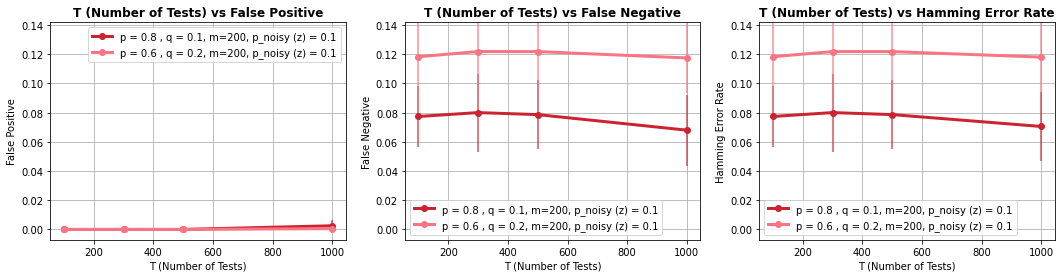

(b): Case 2


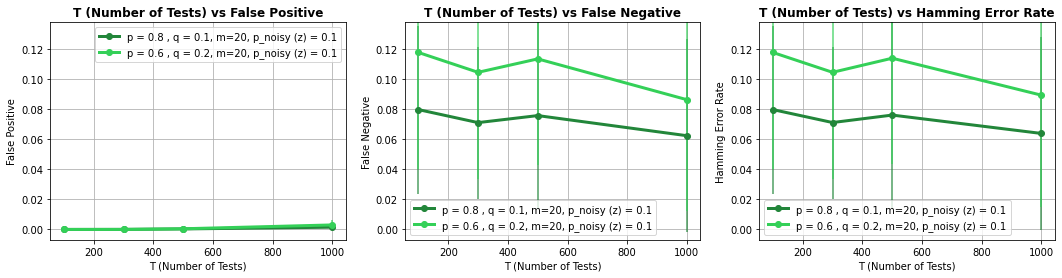

flipping over probability is 0.2
(a): Case 1


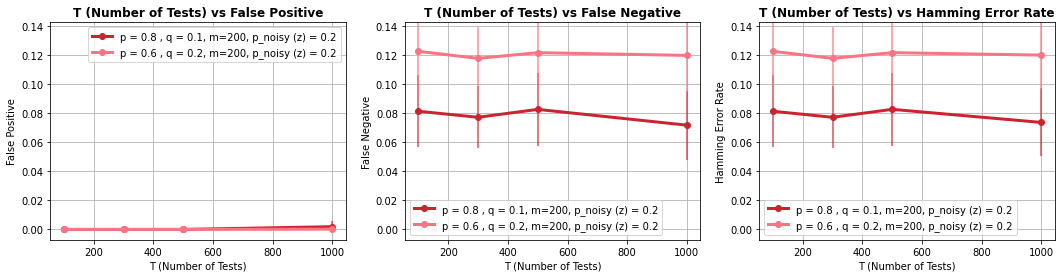

(b): Case 2


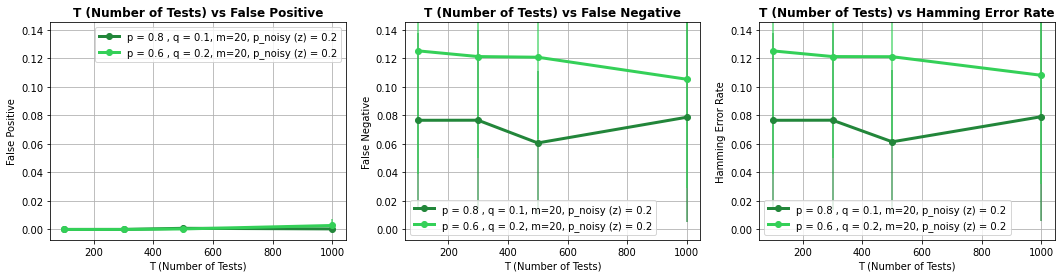

In [10]:
n = 1000
T_list = [100, 300, 500, 1000]
ps = [0.8, 0.6]
qs = [0.1, 0.2]
ms = [200, 20]
p_noisys = [0.1, 0.2]
verbose = False


plot_lp_noisy_bsc_nonoverlapping(n, T_list, ps, qs, ms, p_noisys, num_trial, verbose)